In [1]:
import os,sys,inspect
import os
import joblib
import tensorflow.compat.v1 as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
path_dataset = '/Users/liujiaoyang/tensorflow/MGCNN/Data/Synthetic_Netflix/synthetic_netflix.mat'

In [3]:
# auxiliary functions:

# import matlab files in python
def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

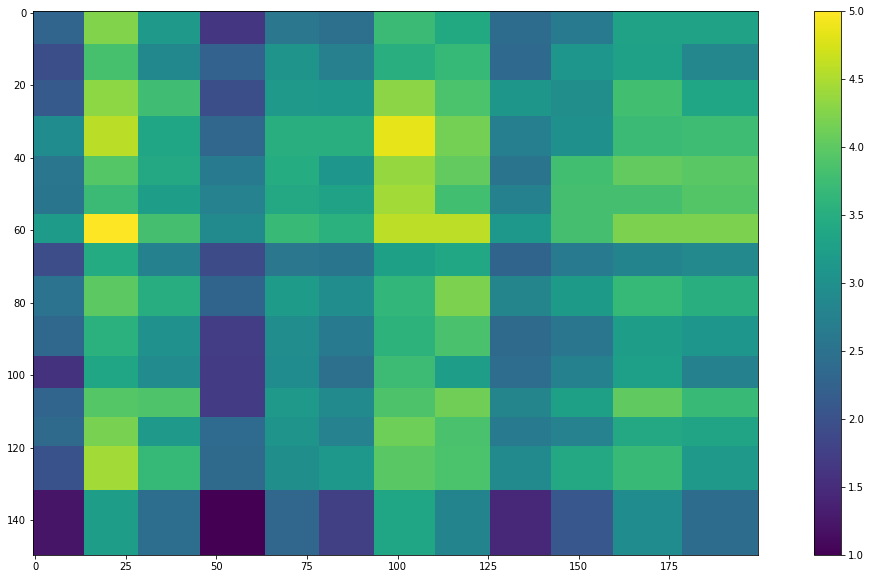

In [4]:
#loading of the required matrices
M = load_matlab_file(path_dataset, 'M')
O = load_matlab_file(path_dataset, 'O')
Otraining = load_matlab_file(path_dataset, 'Otraining')
Otest = load_matlab_file(path_dataset, 'Otest')
Wrow = load_matlab_file(path_dataset, 'Wrow') #sparse
Wcol = load_matlab_file(path_dataset, 'Wcol') #sparse

plt.figure(figsize=(20,10))
plt.imshow(M)
plt.colorbar()

In [23]:
np.random.seed(0)

pos_tr_samples = np.where(Otraining) #训练集中非零值的位置
# print(pos_tr_samples')
num_tr_samples = len(pos_tr_samples[0]) #训练集中非零值的个数
list_idx = list(range(num_tr_samples)) #创建整数列表0 ~ num_tr_samples-1 #修改1，添加list
np.random.shuffle(list_idx) #打乱序列
idx_data = list_idx[:num_tr_samples//2] #取随机序列前一半为data
idx_train = list_idx[num_tr_samples//2:] #取随机序列后一半作为训练数据

pos_data_samples = (pos_tr_samples[0][idx_data], pos_tr_samples[1][idx_data]) #data的位置
pos_tr_samples = (pos_tr_samples[0][idx_train], pos_tr_samples[1][idx_train]) #训练数据的位置

Odata = np.zeros(M.shape) 
Otraining = np.zeros(M.shape)
#print(Odata)

#把Otraining随机分成两个矩阵，Odata,Otraining分别指示非零值的位置
for k in range(len(pos_data_samples[0])):
    Odata[pos_data_samples[0][k], pos_data_samples[1][k]] = 1 #data位置处为1，其余为零
#print(Odata)  

for k in range(len(pos_tr_samples[0])):
    Otraining[pos_tr_samples[0][k], pos_tr_samples[1][k]] = 1 #训练数据位置处为1，其余为零
#print(Otraining)

print ('Num data samples: %d' % (np.sum(Odata),))
print ('Num train samples: %d' % (np.sum(Otraining),))
print ('Num train+data samples: %d' % (np.sum(Odata+Otraining),))

Num data samples: 2250
Num train samples: 2250
Num train+data samples: 4500


In [24]:
#computation of the normalized laplacians
Lrow = sp.csgraph.laplacian(Wrow, normed=True)
Lcol = sp.csgraph.laplacian(Wcol, normed=True)

In [31]:
class Train_test_matrix_completion:
    
    """
    The neural network model.
    """
    #定义范数：平方和再开方
    def frobenius_norm(self, tensor):
        square_tensor = tf.square(tensor)
        tensor_sum = tf.reduce_sum(square_tensor)
        frobenius_norm = tf.sqrt(tensor_sum)
        return frobenius_norm
    
    #定义二维卷积
    def bid_conv(self, W, b): 
        X = tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])
        
        feat = []
        #collect features
        for k_r in range(self.ord_row): #ord_row 行系数
            for k_c in range(self.ord_col):
                row_lap = self.list_row_cheb_pol[k_r] #行切比雪夫多项式
                col_lap = self.list_col_cheb_pol[k_c] #列切比雪夫多项式
                                                     
                #dense implementation
                c_feat = tf.matmul(row_lap, X, a_is_sparse=False) #矩阵乘，频域滤波
                c_feat = tf.matmul(c_feat, col_lap, b_is_sparse=False)
                feat.append(c_feat)
                
        all_feat = tf.stack(feat, 2)
        all_feat = tf.reshape(all_feat, [-1, self.ord_row*self.ord_col])
        conv_feat = tf.matmul(all_feat, W) + b
        conv_feat = tf.nn.relu(conv_feat) #修正方程
        conv_feat = tf.reshape(conv_feat, [tf.shape(self.M)[0], tf.shape(self.M)[1], self.n_conv_feat])
        return conv_feat #返回多图卷积特征
    
    #计算切比雪夫多项式                
    def compute_cheb_polynomials(self, L, ord_cheb, list_cheb):
        for k in range(ord_cheb):
            if (k==0):
                list_cheb.append(tf.cast(tf.compat.v1.diag(tf.ones([tf.shape(L)[0],])), 'float32'))
            elif (k==1):
                list_cheb.append(tf.cast(L, 'float32'))
            else:
                list_cheb.append(2*tf.matmul(L, list_cheb[k-1])  - list_cheb[k-2])
        
    
    def __init__(self, M, Lr, Lc, Odata, Otraining, Otest, order_chebyshev_col = 5, order_chebyshev_row = 5,
                 num_iterations = 10, gamma=1.0, learning_rate=1e-4, idx_gpu = '/gpu:2'):
        
        #order of the spectral filters
        self.ord_col = order_chebyshev_col 
        self.ord_row = order_chebyshev_row
        self.num_iterations = num_iterations
        self.n_conv_feat = 32 #卷积层输出个数
        
        with tf.Graph().as_default() as g:
                tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
                self.graph = g
                tf.set_random_seed(0)
                with tf.device(idx_gpu):
                    
                        #loading of the laplacians
                        self.Lr = tf.constant(Lr.astype('float32'))
                        self.Lc = tf.constant(Lc.astype('float32'))
                        #归一化的拉普拉斯
                        self.norm_Lr = self.Lr - tf.compat.v1.diag(tf.ones([Lr.shape[0], ]))
                        self.norm_Lc = self.Lc - tf.compat.v1.diag(tf.ones([Lc.shape[0], ]))
                        #compute all chebyshev polynomials a priori
                        self.list_row_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lr, self.ord_row, self.list_row_cheb_pol)
                        self.list_col_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lc, self.ord_col, self.list_col_cheb_pol)
                        
                        #definition of constant matrices
                        self.M = tf.constant(M, dtype=tf.float32)
                        self.Odata = tf.constant(Odata, dtype=tf.float32)
                        self.Otraining = tf.constant(Otraining, dtype=tf.float32) #training mask
                        self.Otest = tf.constant(Otest, dtype=tf.float32) #test mask
                         
                        #definition of the NN variables
                        self.W_conv = tf.get_variable("W_conv", shape=[self.ord_col*self.ord_row, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_conv = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #recurrent N parameters
                        self.W_f = tf.get_variable("W_f", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_i = tf.get_variable("W_i", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_o = tf.get_variable("W_o", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_c = tf.get_variable("W_c", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_f = tf.get_variable("U_f", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_i = tf.get_variable("U_i", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_o = tf.get_variable("U_o", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_c = tf.get_variable("U_c", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_f = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_i = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_o = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_c = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #output parameters
                        self.W_out = tf.get_variable("W_out", shape=[self.n_conv_feat,1], initializer=tf.glorot_uniform_initializer()) 
                        self.b_out = tf.Variable(tf.zeros([1,1]))
                        
                        #########definition of the NN
                        self.X = tf.multiply(self.M, self.Odata) #we may initialize it at random here #初始化待填充矩阵X
                        self.list_X = list()
                        self.list_X.append(tf.identity(self.X))
                        self.X = tf.reshape(self.X, [-1,])
                        
                        #RNN
                        self.h = tf.zeros([M.shape[0]*M.shape[1], self.n_conv_feat])
                        self.c = tf.zeros([M.shape[0]*M.shape[1], self.n_conv_feat])
                        
                        for k in range(self.num_iterations):
                            #bidimensional convolution
                            self.x_conv = self.bid_conv(self.W_conv, self.b_conv) #N, N, n_conv_feat
                            self.x_conv = tf.reshape(self.x_conv, [-1, self.n_conv_feat])
                            
                            self.f = tf.sigmoid(tf.matmul(self.x_conv, self.W_f) + tf.matmul(self.h, self.U_f) + self.b_f)
                            self.i = tf.sigmoid(tf.matmul(self.x_conv, self.W_i) + tf.matmul(self.h, self.U_i) + self.b_i)
                            self.o = tf.sigmoid(tf.matmul(self.x_conv, self.W_o) + tf.matmul(self.h, self.U_o) + self.b_o)
                            
                            self.update_c = tf.sigmoid(tf.matmul(self.x_conv, self.W_c) + tf.matmul(self.h, self.U_c) + self.b_c)
                            self.c = tf.multiply(self.f, self.c) + tf.multiply(self.i, self.update_c)
                            self.h = tf.multiply(self.o, tf.sigmoid(self.c))
                            
                            #compute update of matrix X
                            self.delta_x = tf.tanh(tf.matmul(self.c, self.W_out) + self.b_out)
                            self.X += tf.squeeze(self.delta_x)
                            self.list_X.append(tf.identity(tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])))
                            
                            
                        self.X = tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])
                        #########loss definition
                        
                        #computation of the accuracy term
                        self.norm_X = 1+4*(self.X-tf.reduce_min(self.X))/(tf.reduce_max(self.X-tf.reduce_min(self.X)))
                        frob_tensor = tf.multiply(self.Otraining + self.Odata, self.norm_X - M)
                        self.loss_frob = tf.square(self.frobenius_norm(frob_tensor))/np.sum(Otraining+Odata)
                        
                        #computation of the regularization terms
                        trace_col_tensor = tf.matmul(tf.matmul(self.X, self.Lc), self.X, transpose_b=True)
                        self.loss_trace_col = tf.trace(trace_col_tensor)
                        trace_row_tensor = tf.matmul(tf.matmul(self.X, self.Lr, transpose_a=True), self.X)
                        self.loss_trace_row = tf.trace(trace_row_tensor)
                        
                        #training loss definition
                        self.loss = self.loss_frob + (gamma/2)*(self.loss_trace_col + self.loss_trace_row)
                        
                        #test loss definition
                        self.predictions = tf.multiply(self.Otest, self.norm_X - self.M)
                        self.predictions_error = self.frobenius_norm(self.predictions)

                        #definition of the solver
                        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
                        
                        self.var_grad = tf.gradients(self.loss, tf.trainable_variables())
                        self.norm_grad = self.frobenius_norm(tf.concat([tf.reshape(g, [-1]) for g in self.var_grad], 0))

                        # Create a session for running Ops on the Graph.
                        config = tf.ConfigProto(allow_soft_placement = True)
                        config.gpu_options.allow_growth = True
                        self.session = tf.Session(config=config)

                        # Run the Op to initialize the variables.
                        init = tf.initialize_all_variables()
                        self.session.run(init)

In [32]:
ord_col = 5
ord_row = 5

learning_obj = Train_test_matrix_completion(M, Lrow.toarray(), Lcol.toarray(), Odata, Otraining, Otest, 
                                            order_chebyshev_col = ord_col, order_chebyshev_row = ord_row, 
                                            gamma=1e-8, learning_rate=1e-3)

num_iter_test = 10
num_total_iter_training = 25000

num_iter = 0

list_training_loss = list()
list_training_norm_grad = list()
list_test_pred_error = list()
list_predictions = list()
list_X = list()

list_training_times = list()
list_test_times = list()
list_grad_X = list()

list_X_evolutions = list()

In [35]:
num_iter = 0
for k in range(num_iter, num_total_iter_training):

    tic = time.time()
    _, current_training_loss, norm_grad, X_grad = learning_obj.session.run([learning_obj.optimizer, learning_obj.loss, 
                                                                            learning_obj.norm_grad, learning_obj.var_grad]) 
    training_time = time.time() - tic

    list_training_loss.append(current_training_loss)
    list_training_norm_grad.append(norm_grad)
    list_training_times.append(training_time)
        
    if (np.mod(num_iter, num_iter_test)==0):
        msg = "[TRN] iter = %03i, cost = %3.2e, |grad| = %.2e (%3.2es)" \
                                    % (num_iter, list_training_loss[-1], list_training_norm_grad[-1], training_time)
        print (msg)
            
        #Test Code
        tic = time.time()
        pred_error, preds, X = learning_obj.session.run([learning_obj.predictions_error, learning_obj.predictions,
                                                                             learning_obj.norm_X]) 
        c_X_evolutions = learning_obj.session.run(learning_obj.list_X)
        list_X_evolutions.append(c_X_evolutions)

        test_time = time.time() - tic

        list_test_pred_error.append(pred_error)
        list_X.append(X)
        list_test_times.append(test_time)
        msg =  "[TST] iter = %03i, cost = %3.2e (%3.2es)" % (num_iter, list_test_pred_error[-1], test_time)
        print (msg)
            
    num_iter += 1

[TRN] iter = 000, cost = 1.86e+00, |grad| = 6.99e+00 (2.99e+00s)
[TST] iter = 000, cost = 1.17e+02 (8.84e-01s)
[TRN] iter = 010, cost = 5.14e-01, |grad| = 5.17e+00 (6.44e-01s)
[TST] iter = 010, cost = 4.46e+01 (2.70e-01s)
[TRN] iter = 020, cost = 2.90e-01, |grad| = 2.93e+00 (6.22e-01s)
[TST] iter = 020, cost = 3.74e+01 (2.71e-01s)
[TRN] iter = 030, cost = 2.08e-01, |grad| = 4.03e+00 (6.38e-01s)
[TST] iter = 030, cost = 3.27e+01 (2.71e-01s)
[TRN] iter = 040, cost = 1.66e-01, |grad| = 2.20e+00 (6.26e-01s)
[TST] iter = 040, cost = 2.92e+01 (2.88e-01s)
[TRN] iter = 050, cost = 1.28e-01, |grad| = 7.11e-01 (6.18e-01s)
[TST] iter = 050, cost = 2.63e+01 (2.78e-01s)
[TRN] iter = 060, cost = 9.95e-02, |grad| = 4.08e-01 (6.21e-01s)
[TST] iter = 060, cost = 2.32e+01 (2.72e-01s)
[TRN] iter = 070, cost = 7.93e-02, |grad| = 9.14e-01 (6.27e-01s)
[TST] iter = 070, cost = 2.03e+01 (2.72e-01s)
[TRN] iter = 080, cost = 6.58e-02, |grad| = 5.29e-01 (6.23e-01s)
[TST] iter = 080, cost = 1.84e+01 (2.77e-01s)
[

[TRN] iter = 740, cost = 4.10e-03, |grad| = 1.22e-02 (7.13e-01s)
[TST] iter = 740, cost = 4.35e+00 (2.75e-01s)
[TRN] iter = 750, cost = 4.02e-03, |grad| = 1.28e-02 (6.58e-01s)
[TST] iter = 750, cost = 4.31e+00 (2.94e-01s)
[TRN] iter = 760, cost = 3.93e-03, |grad| = 1.15e-02 (6.43e-01s)
[TST] iter = 760, cost = 4.26e+00 (2.83e-01s)
[TRN] iter = 770, cost = 3.85e-03, |grad| = 1.17e-02 (6.39e-01s)
[TST] iter = 770, cost = 4.22e+00 (2.94e-01s)
[TRN] iter = 780, cost = 3.78e-03, |grad| = 1.15e-02 (6.51e-01s)
[TST] iter = 780, cost = 4.17e+00 (3.12e-01s)
[TRN] iter = 790, cost = 3.70e-03, |grad| = 1.13e-02 (6.51e-01s)
[TST] iter = 790, cost = 4.13e+00 (2.87e-01s)
[TRN] iter = 800, cost = 3.62e-03, |grad| = 1.07e-02 (6.48e-01s)
[TST] iter = 800, cost = 4.08e+00 (3.02e-01s)
[TRN] iter = 810, cost = 3.55e-03, |grad| = 1.07e-02 (6.72e-01s)
[TST] iter = 810, cost = 4.04e+00 (2.98e-01s)
[TRN] iter = 820, cost = 3.47e-03, |grad| = 1.08e-02 (6.91e-01s)
[TST] iter = 820, cost = 4.00e+00 (3.03e-01s)
[

[TRN] iter = 1470, cost = 1.22e-03, |grad| = 7.67e-03 (6.74e-01s)
[TST] iter = 1470, cost = 2.33e+00 (2.87e-01s)
[TRN] iter = 1480, cost = 1.21e-03, |grad| = 4.26e-03 (6.54e-01s)
[TST] iter = 1480, cost = 2.32e+00 (3.04e-01s)
[TRN] iter = 1490, cost = 1.20e-03, |grad| = 8.86e-03 (6.68e-01s)
[TST] iter = 1490, cost = 2.31e+00 (2.95e-01s)
[TRN] iter = 1500, cost = 1.19e-03, |grad| = 2.14e-02 (6.75e-01s)
[TST] iter = 1500, cost = 2.30e+00 (3.06e-01s)
[TRN] iter = 1510, cost = 1.17e-03, |grad| = 8.91e-03 (6.85e-01s)
[TST] iter = 1510, cost = 2.29e+00 (2.99e-01s)
[TRN] iter = 1520, cost = 1.16e-03, |grad| = 4.71e-03 (6.95e-01s)
[TST] iter = 1520, cost = 2.28e+00 (3.04e-01s)
[TRN] iter = 1530, cost = 1.15e-03, |grad| = 9.50e-03 (6.58e-01s)
[TST] iter = 1530, cost = 2.27e+00 (2.91e-01s)
[TRN] iter = 1540, cost = 1.14e-03, |grad| = 1.38e-02 (6.52e-01s)
[TST] iter = 1540, cost = 2.26e+00 (2.99e-01s)
[TRN] iter = 1550, cost = 1.13e-03, |grad| = 9.63e-03 (6.72e-01s)
[TST] iter = 1550, cost = 2.25

[TST] iter = 2190, cost = 1.77e+00 (2.98e-01s)
[TRN] iter = 2200, cost = 6.86e-04, |grad| = 1.64e-02 (7.11e-01s)
[TST] iter = 2200, cost = 1.76e+00 (3.18e-01s)
[TRN] iter = 2210, cost = 6.83e-04, |grad| = 2.54e-02 (6.88e-01s)
[TST] iter = 2210, cost = 1.76e+00 (3.21e-01s)
[TRN] iter = 2220, cost = 6.78e-04, |grad| = 1.81e-02 (6.85e-01s)
[TST] iter = 2220, cost = 1.75e+00 (3.16e-01s)
[TRN] iter = 2230, cost = 6.73e-04, |grad| = 8.40e-03 (6.83e-01s)
[TST] iter = 2230, cost = 1.75e+00 (3.08e-01s)
[TRN] iter = 2240, cost = 6.69e-04, |grad| = 1.52e-02 (6.88e-01s)
[TST] iter = 2240, cost = 1.74e+00 (3.05e-01s)
[TRN] iter = 2250, cost = 6.65e-04, |grad| = 1.13e-02 (6.83e-01s)
[TST] iter = 2250, cost = 1.74e+00 (3.25e-01s)
[TRN] iter = 2260, cost = 6.60e-04, |grad| = 7.45e-03 (6.92e-01s)
[TST] iter = 2260, cost = 1.73e+00 (3.20e-01s)
[TRN] iter = 2270, cost = 6.56e-04, |grad| = 8.08e-03 (6.93e-01s)
[TST] iter = 2270, cost = 1.73e+00 (3.00e-01s)
[TRN] iter = 2280, cost = 6.52e-04, |grad| = 7.62

[TST] iter = 2920, cost = 1.44e+00 (3.05e-01s)
[TRN] iter = 2930, cost = 4.42e-04, |grad| = 6.31e-03 (6.72e-01s)
[TST] iter = 2930, cost = 1.43e+00 (2.99e-01s)
[TRN] iter = 2940, cost = 4.40e-04, |grad| = 1.47e-03 (6.83e-01s)
[TST] iter = 2940, cost = 1.43e+00 (3.04e-01s)
[TRN] iter = 2950, cost = 4.38e-04, |grad| = 8.03e-03 (6.70e-01s)
[TST] iter = 2950, cost = 1.42e+00 (3.04e-01s)
[TRN] iter = 2960, cost = 4.35e-04, |grad| = 9.47e-03 (6.64e-01s)
[TST] iter = 2960, cost = 1.42e+00 (3.08e-01s)
[TRN] iter = 2970, cost = 4.33e-04, |grad| = 2.44e-03 (6.72e-01s)
[TST] iter = 2970, cost = 1.42e+00 (3.00e-01s)
[TRN] iter = 2980, cost = 4.31e-04, |grad| = 9.85e-03 (6.81e-01s)
[TST] iter = 2980, cost = 1.41e+00 (3.14e-01s)
[TRN] iter = 2990, cost = 4.28e-04, |grad| = 2.18e-03 (6.62e-01s)
[TST] iter = 2990, cost = 1.41e+00 (3.14e-01s)
[TRN] iter = 3000, cost = 4.26e-04, |grad| = 7.82e-03 (6.51e-01s)
[TST] iter = 3000, cost = 1.41e+00 (3.06e-01s)
[TRN] iter = 3010, cost = 4.24e-04, |grad| = 3.35

[TST] iter = 3650, cost = 1.67e+00 (2.99e-01s)
[TRN] iter = 3660, cost = 6.58e-04, |grad| = 3.34e-03 (6.83e-01s)
[TST] iter = 3660, cost = 1.66e+00 (3.15e-01s)
[TRN] iter = 3670, cost = 6.48e-04, |grad| = 3.39e-03 (6.78e-01s)
[TST] iter = 3670, cost = 1.65e+00 (2.97e-01s)
[TRN] iter = 3680, cost = 6.38e-04, |grad| = 4.13e-03 (6.83e-01s)
[TST] iter = 3680, cost = 1.64e+00 (2.95e-01s)
[TRN] iter = 3690, cost = 6.28e-04, |grad| = 4.91e-03 (6.75e-01s)
[TST] iter = 3690, cost = 1.62e+00 (2.99e-01s)
[TRN] iter = 3700, cost = 6.19e-04, |grad| = 2.67e-03 (7.50e-01s)
[TST] iter = 3700, cost = 1.61e+00 (3.28e-01s)
[TRN] iter = 3710, cost = 6.09e-04, |grad| = 7.37e-03 (7.38e-01s)
[TST] iter = 3710, cost = 1.60e+00 (3.26e-01s)
[TRN] iter = 3720, cost = 6.00e-04, |grad| = 2.90e-03 (7.20e-01s)
[TST] iter = 3720, cost = 1.58e+00 (3.08e-01s)
[TRN] iter = 3730, cost = 5.91e-04, |grad| = 1.91e-03 (6.75e-01s)
[TST] iter = 3730, cost = 1.58e+00 (2.98e-01s)
[TRN] iter = 3740, cost = 5.83e-04, |grad| = 1.92

[TST] iter = 4380, cost = 1.17e+00 (3.01e-01s)
[TRN] iter = 4390, cost = 3.22e-04, |grad| = 1.06e-03 (6.71e-01s)
[TST] iter = 4390, cost = 1.16e+00 (2.97e-01s)
[TRN] iter = 4400, cost = 3.19e-04, |grad| = 1.13e-03 (6.70e-01s)
[TST] iter = 4400, cost = 1.16e+00 (3.05e-01s)
[TRN] iter = 4410, cost = 3.17e-04, |grad| = 1.41e-03 (6.48e-01s)
[TST] iter = 4410, cost = 1.16e+00 (2.97e-01s)
[TRN] iter = 4420, cost = 3.14e-04, |grad| = 9.25e-04 (6.84e-01s)
[TST] iter = 4420, cost = 1.15e+00 (2.88e-01s)
[TRN] iter = 4430, cost = 3.11e-04, |grad| = 1.53e-03 (6.55e-01s)
[TST] iter = 4430, cost = 1.15e+00 (3.17e-01s)
[TRN] iter = 4440, cost = 3.09e-04, |grad| = 9.48e-04 (6.75e-01s)
[TST] iter = 4440, cost = 1.14e+00 (3.01e-01s)
[TRN] iter = 4450, cost = 3.06e-04, |grad| = 1.06e-03 (6.56e-01s)
[TST] iter = 4450, cost = 1.14e+00 (2.98e-01s)
[TRN] iter = 4460, cost = 3.04e-04, |grad| = 1.91e-03 (6.96e-01s)
[TST] iter = 4460, cost = 1.14e+00 (3.03e-01s)
[TRN] iter = 4470, cost = 3.02e-04, |grad| = 1.32

[TST] iter = 5110, cost = 9.57e-01 (3.22e-01s)
[TRN] iter = 5120, cost = 2.15e-04, |grad| = 6.95e-04 (6.95e-01s)
[TST] iter = 5120, cost = 9.55e-01 (3.17e-01s)
[TRN] iter = 5130, cost = 2.14e-04, |grad| = 5.09e-04 (6.90e-01s)
[TST] iter = 5130, cost = 9.53e-01 (3.14e-01s)
[TRN] iter = 5140, cost = 2.13e-04, |grad| = 3.59e-03 (7.09e-01s)
[TST] iter = 5140, cost = 9.51e-01 (3.13e-01s)
[TRN] iter = 5150, cost = 2.12e-04, |grad| = 5.59e-04 (7.35e-01s)
[TST] iter = 5150, cost = 9.50e-01 (3.10e-01s)
[TRN] iter = 5160, cost = 2.12e-04, |grad| = 1.39e-03 (7.11e-01s)
[TST] iter = 5160, cost = 9.48e-01 (3.29e-01s)
[TRN] iter = 5170, cost = 2.11e-04, |grad| = 2.51e-03 (6.85e-01s)
[TST] iter = 5170, cost = 9.46e-01 (3.26e-01s)
[TRN] iter = 5180, cost = 2.10e-04, |grad| = 2.17e-03 (6.99e-01s)
[TST] iter = 5180, cost = 9.44e-01 (3.15e-01s)
[TRN] iter = 5190, cost = 2.09e-04, |grad| = 2.25e-03 (7.15e-01s)
[TST] iter = 5190, cost = 9.42e-01 (3.17e-01s)
[TRN] iter = 5200, cost = 2.08e-04, |grad| = 3.15

[TST] iter = 5840, cost = 8.70e-01 (3.03e-01s)
[TRN] iter = 5850, cost = 1.83e-04, |grad| = 5.49e-02 (6.65e-01s)
[TST] iter = 5850, cost = 8.67e-01 (3.08e-01s)
[TRN] iter = 5860, cost = 1.72e-04, |grad| = 7.99e-03 (6.72e-01s)
[TST] iter = 5860, cost = 8.46e-01 (3.17e-01s)
[TRN] iter = 5870, cost = 1.72e-04, |grad| = 1.12e-02 (6.73e-01s)
[TST] iter = 5870, cost = 8.54e-01 (3.15e-01s)
[TRN] iter = 5880, cost = 1.74e-04, |grad| = 2.56e-02 (6.62e-01s)
[TST] iter = 5880, cost = 8.73e-01 (2.84e-01s)
[TRN] iter = 5890, cost = 1.70e-04, |grad| = 2.22e-02 (6.53e-01s)
[TST] iter = 5890, cost = 8.67e-01 (3.07e-01s)
[TRN] iter = 5900, cost = 1.81e-04, |grad| = 7.49e-02 (6.77e-01s)
[TST] iter = 5900, cost = 9.25e-01 (3.08e-01s)
[TRN] iter = 5910, cost = 2.55e-04, |grad| = 3.25e-02 (6.94e-01s)
[TST] iter = 5910, cost = 1.19e+00 (3.08e-01s)
[TRN] iter = 5920, cost = 3.23e-04, |grad| = 8.38e-02 (6.74e-01s)
[TST] iter = 5920, cost = 1.05e+00 (3.11e-01s)
[TRN] iter = 5930, cost = 1.75e-03, |grad| = 2.59

[TST] iter = 6570, cost = 1.87e+00 (3.36e-01s)
[TRN] iter = 6580, cost = 7.50e-04, |grad| = 3.10e-03 (7.04e-01s)
[TST] iter = 6580, cost = 1.86e+00 (3.15e-01s)
[TRN] iter = 6590, cost = 7.39e-04, |grad| = 2.94e-03 (7.28e-01s)
[TST] iter = 6590, cost = 1.84e+00 (3.19e-01s)
[TRN] iter = 6600, cost = 7.29e-04, |grad| = 2.84e-03 (7.31e-01s)
[TST] iter = 6600, cost = 1.83e+00 (3.23e-01s)
[TRN] iter = 6610, cost = 7.19e-04, |grad| = 2.88e-03 (7.02e-01s)
[TST] iter = 6610, cost = 1.82e+00 (3.41e-01s)
[TRN] iter = 6620, cost = 7.09e-04, |grad| = 2.69e-03 (6.94e-01s)
[TST] iter = 6620, cost = 1.81e+00 (3.26e-01s)
[TRN] iter = 6630, cost = 7.00e-04, |grad| = 2.55e-03 (6.85e-01s)
[TST] iter = 6630, cost = 1.79e+00 (3.21e-01s)
[TRN] iter = 6640, cost = 6.91e-04, |grad| = 2.54e-03 (6.74e-01s)
[TST] iter = 6640, cost = 1.78e+00 (3.11e-01s)
[TRN] iter = 6650, cost = 6.83e-04, |grad| = 2.38e-03 (6.90e-01s)
[TST] iter = 6650, cost = 1.77e+00 (3.08e-01s)
[TRN] iter = 6660, cost = 6.75e-04, |grad| = 2.34

[TST] iter = 7300, cost = 1.34e+00 (3.19e-01s)
[TRN] iter = 7310, cost = 3.97e-04, |grad| = 1.11e-03 (6.91e-01s)
[TST] iter = 7310, cost = 1.34e+00 (3.33e-01s)
[TRN] iter = 7320, cost = 3.94e-04, |grad| = 1.09e-03 (6.61e-01s)
[TST] iter = 7320, cost = 1.33e+00 (3.15e-01s)
[TRN] iter = 7330, cost = 3.92e-04, |grad| = 9.66e-04 (6.96e-01s)
[TST] iter = 7330, cost = 1.33e+00 (3.18e-01s)
[TRN] iter = 7340, cost = 3.90e-04, |grad| = 1.07e-03 (6.93e-01s)
[TST] iter = 7340, cost = 1.33e+00 (3.18e-01s)
[TRN] iter = 7350, cost = 3.88e-04, |grad| = 9.24e-04 (7.03e-01s)
[TST] iter = 7350, cost = 1.32e+00 (3.12e-01s)
[TRN] iter = 7360, cost = 3.86e-04, |grad| = 8.92e-04 (7.27e-01s)
[TST] iter = 7360, cost = 1.32e+00 (3.57e-01s)
[TRN] iter = 7370, cost = 3.84e-04, |grad| = 1.02e-03 (7.44e-01s)
[TST] iter = 7370, cost = 1.32e+00 (3.38e-01s)
[TRN] iter = 7380, cost = 3.82e-04, |grad| = 9.03e-04 (6.85e-01s)
[TST] iter = 7380, cost = 1.31e+00 (3.22e-01s)
[TRN] iter = 7390, cost = 3.80e-04, |grad| = 9.61

[TST] iter = 8030, cost = 1.15e+00 (3.04e-01s)
[TRN] iter = 8040, cost = 2.92e-04, |grad| = 5.75e-04 (6.97e-01s)
[TST] iter = 8040, cost = 1.15e+00 (3.18e-01s)
[TRN] iter = 8050, cost = 2.91e-04, |grad| = 5.50e-04 (7.19e-01s)
[TST] iter = 8050, cost = 1.14e+00 (3.29e-01s)
[TRN] iter = 8060, cost = 2.90e-04, |grad| = 5.36e-04 (6.85e-01s)
[TST] iter = 8060, cost = 1.14e+00 (3.34e-01s)
[TRN] iter = 8070, cost = 2.89e-04, |grad| = 6.27e-04 (6.92e-01s)
[TST] iter = 8070, cost = 1.14e+00 (3.10e-01s)
[TRN] iter = 8080, cost = 2.88e-04, |grad| = 5.40e-04 (6.85e-01s)
[TST] iter = 8080, cost = 1.14e+00 (3.17e-01s)
[TRN] iter = 8090, cost = 2.87e-04, |grad| = 1.05e-03 (6.79e-01s)
[TST] iter = 8090, cost = 1.14e+00 (3.12e-01s)
[TRN] iter = 8100, cost = 2.86e-04, |grad| = 5.33e-04 (7.25e-01s)
[TST] iter = 8100, cost = 1.13e+00 (3.06e-01s)
[TRN] iter = 8110, cost = 2.85e-04, |grad| = 6.33e-04 (6.97e-01s)
[TST] iter = 8110, cost = 1.13e+00 (3.31e-01s)
[TRN] iter = 8120, cost = 2.84e-04, |grad| = 6.21

[TST] iter = 8760, cost = 1.01e+00 (3.33e-01s)
[TRN] iter = 8770, cost = 2.28e-04, |grad| = 5.00e-04 (6.91e-01s)
[TST] iter = 8770, cost = 1.01e+00 (3.02e-01s)
[TRN] iter = 8780, cost = 2.27e-04, |grad| = 3.74e-04 (6.89e-01s)
[TST] iter = 8780, cost = 1.00e+00 (3.08e-01s)
[TRN] iter = 8790, cost = 2.26e-04, |grad| = 6.78e-04 (6.72e-01s)
[TST] iter = 8790, cost = 1.00e+00 (3.09e-01s)
[TRN] iter = 8800, cost = 2.25e-04, |grad| = 7.04e-04 (6.97e-01s)
[TST] iter = 8800, cost = 1.00e+00 (3.17e-01s)
[TRN] iter = 8810, cost = 2.25e-04, |grad| = 5.70e-04 (7.17e-01s)
[TST] iter = 8810, cost = 9.99e-01 (3.04e-01s)
[TRN] iter = 8820, cost = 2.24e-04, |grad| = 4.25e-04 (7.20e-01s)
[TST] iter = 8820, cost = 9.97e-01 (3.21e-01s)
[TRN] iter = 8830, cost = 2.23e-04, |grad| = 7.57e-04 (7.04e-01s)
[TST] iter = 8830, cost = 9.95e-01 (3.27e-01s)
[TRN] iter = 8840, cost = 2.23e-04, |grad| = 3.75e-04 (7.28e-01s)
[TST] iter = 8840, cost = 9.94e-01 (3.22e-01s)
[TRN] iter = 8850, cost = 2.22e-04, |grad| = 5.41

[TST] iter = 9490, cost = 8.94e-01 (3.30e-01s)
[TRN] iter = 9500, cost = 1.82e-04, |grad| = 4.31e-04 (6.78e-01s)
[TST] iter = 9500, cost = 8.92e-01 (3.25e-01s)
[TRN] iter = 9510, cost = 1.81e-04, |grad| = 2.70e-04 (7.32e-01s)
[TST] iter = 9510, cost = 8.91e-01 (3.35e-01s)
[TRN] iter = 9520, cost = 1.81e-04, |grad| = 7.05e-04 (6.98e-01s)
[TST] iter = 9520, cost = 8.89e-01 (3.35e-01s)
[TRN] iter = 9530, cost = 1.80e-04, |grad| = 4.58e-04 (6.82e-01s)
[TST] iter = 9530, cost = 8.88e-01 (3.19e-01s)
[TRN] iter = 9540, cost = 1.80e-04, |grad| = 2.75e-04 (6.93e-01s)
[TST] iter = 9540, cost = 8.87e-01 (3.13e-01s)
[TRN] iter = 9550, cost = 1.79e-04, |grad| = 5.09e-04 (6.83e-01s)
[TST] iter = 9550, cost = 8.85e-01 (2.92e-01s)
[TRN] iter = 9560, cost = 1.79e-04, |grad| = 2.81e-04 (6.98e-01s)
[TST] iter = 9560, cost = 8.84e-01 (3.07e-01s)
[TRN] iter = 9570, cost = 1.78e-04, |grad| = 4.28e-04 (6.91e-01s)
[TST] iter = 9570, cost = 8.83e-01 (3.01e-01s)
[TRN] iter = 9580, cost = 1.78e-04, |grad| = 4.72

[TRN] iter = 10220, cost = 1.51e-04, |grad| = 2.04e-04 (6.59e-01s)
[TST] iter = 10220, cost = 8.08e-01 (3.02e-01s)
[TRN] iter = 10230, cost = 1.51e-04, |grad| = 2.54e-04 (6.72e-01s)
[TST] iter = 10230, cost = 8.06e-01 (3.01e-01s)
[TRN] iter = 10240, cost = 1.50e-04, |grad| = 3.25e-04 (6.67e-01s)
[TST] iter = 10240, cost = 8.05e-01 (2.96e-01s)
[TRN] iter = 10250, cost = 1.50e-04, |grad| = 3.25e-04 (6.68e-01s)
[TST] iter = 10250, cost = 8.04e-01 (3.08e-01s)
[TRN] iter = 10260, cost = 1.50e-04, |grad| = 3.89e-04 (6.66e-01s)
[TST] iter = 10260, cost = 8.03e-01 (2.98e-01s)
[TRN] iter = 10270, cost = 1.49e-04, |grad| = 3.53e-04 (6.65e-01s)
[TST] iter = 10270, cost = 8.02e-01 (3.09e-01s)
[TRN] iter = 10280, cost = 1.49e-04, |grad| = 2.36e-04 (6.67e-01s)
[TST] iter = 10280, cost = 8.01e-01 (2.95e-01s)
[TRN] iter = 10290, cost = 1.49e-04, |grad| = 2.06e-04 (6.76e-01s)
[TST] iter = 10290, cost = 8.00e-01 (2.98e-01s)
[TRN] iter = 10300, cost = 1.48e-04, |grad| = 2.65e-04 (6.61e-01s)
[TST] iter = 

[TST] iter = 10930, cost = 7.38e-01 (3.11e-01s)
[TRN] iter = 10940, cost = 1.27e-04, |grad| = 5.99e-04 (6.76e-01s)
[TST] iter = 10940, cost = 7.37e-01 (3.10e-01s)
[TRN] iter = 10950, cost = 1.27e-04, |grad| = 2.92e-04 (6.96e-01s)
[TST] iter = 10950, cost = 7.37e-01 (3.18e-01s)
[TRN] iter = 10960, cost = 1.26e-04, |grad| = 3.56e-04 (6.20e-01s)
[TST] iter = 10960, cost = 7.36e-01 (3.13e-01s)
[TRN] iter = 10970, cost = 1.26e-04, |grad| = 7.18e-04 (6.94e-01s)
[TST] iter = 10970, cost = 7.35e-01 (3.11e-01s)
[TRN] iter = 10980, cost = 1.26e-04, |grad| = 5.87e-04 (6.85e-01s)
[TST] iter = 10980, cost = 7.34e-01 (3.15e-01s)
[TRN] iter = 10990, cost = 1.26e-04, |grad| = 6.62e-04 (6.78e-01s)
[TST] iter = 10990, cost = 7.33e-01 (3.09e-01s)
[TRN] iter = 11000, cost = 1.25e-04, |grad| = 3.57e-04 (6.76e-01s)
[TST] iter = 11000, cost = 7.32e-01 (3.17e-01s)
[TRN] iter = 11010, cost = 1.25e-04, |grad| = 3.24e-04 (6.92e-01s)
[TST] iter = 11010, cost = 7.31e-01 (3.15e-01s)
[TRN] iter = 11020, cost = 1.25e

[TRN] iter = 11650, cost = 1.08e-04, |grad| = 2.25e-03 (6.65e-01s)
[TST] iter = 11650, cost = 6.80e-01 (2.93e-01s)
[TRN] iter = 11660, cost = 1.09e-04, |grad| = 8.32e-03 (6.68e-01s)
[TST] iter = 11660, cost = 6.85e-01 (2.97e-01s)
[TRN] iter = 11670, cost = 1.13e-04, |grad| = 7.80e-03 (6.59e-01s)
[TST] iter = 11670, cost = 6.91e-01 (3.09e-01s)
[TRN] iter = 11680, cost = 1.14e-04, |grad| = 1.61e-02 (6.43e-01s)
[TST] iter = 11680, cost = 6.84e-01 (3.07e-01s)
[TRN] iter = 11690, cost = 1.12e-04, |grad| = 1.63e-02 (6.78e-01s)
[TST] iter = 11690, cost = 6.94e-01 (3.09e-01s)
[TRN] iter = 11700, cost = 1.08e-04, |grad| = 3.45e-03 (6.60e-01s)
[TST] iter = 11700, cost = 6.76e-01 (2.89e-01s)
[TRN] iter = 11710, cost = 1.26e-04, |grad| = 3.69e-02 (6.54e-01s)
[TST] iter = 11710, cost = 7.44e-01 (3.07e-01s)
[TRN] iter = 11720, cost = 1.13e-04, |grad| = 1.99e-02 (6.68e-01s)
[TST] iter = 11720, cost = 6.96e-01 (3.11e-01s)
[TRN] iter = 11730, cost = 1.88e-04, |grad| = 2.13e-02 (6.76e-01s)
[TST] iter = 

[TST] iter = 12360, cost = 7.74e-01 (3.05e-01s)
[TRN] iter = 12370, cost = 1.60e-04, |grad| = 6.94e-04 (7.14e-01s)
[TST] iter = 12370, cost = 7.71e-01 (3.12e-01s)
[TRN] iter = 12380, cost = 1.59e-04, |grad| = 1.72e-03 (7.31e-01s)
[TST] iter = 12380, cost = 7.69e-01 (3.31e-01s)
[TRN] iter = 12390, cost = 1.58e-04, |grad| = 8.22e-04 (6.79e-01s)
[TST] iter = 12390, cost = 7.66e-01 (3.15e-01s)
[TRN] iter = 12400, cost = 1.58e-04, |grad| = 2.88e-04 (6.85e-01s)
[TST] iter = 12400, cost = 7.63e-01 (3.15e-01s)
[TRN] iter = 12410, cost = 1.57e-04, |grad| = 6.32e-04 (6.89e-01s)
[TST] iter = 12410, cost = 7.61e-01 (3.11e-01s)
[TRN] iter = 12420, cost = 1.56e-04, |grad| = 7.11e-04 (6.94e-01s)
[TST] iter = 12420, cost = 7.60e-01 (3.11e-01s)
[TRN] iter = 12430, cost = 1.55e-04, |grad| = 5.66e-04 (6.83e-01s)
[TST] iter = 12430, cost = 7.57e-01 (3.10e-01s)
[TRN] iter = 12440, cost = 1.54e-04, |grad| = 6.90e-04 (6.91e-01s)
[TST] iter = 12440, cost = 7.54e-01 (3.10e-01s)
[TRN] iter = 12450, cost = 1.54e

[TRN] iter = 13080, cost = 1.20e-04, |grad| = 6.77e-03 (7.27e-01s)
[TST] iter = 13080, cost = 6.55e-01 (3.63e-01s)
[TRN] iter = 13090, cost = 1.20e-04, |grad| = 3.97e-03 (7.29e-01s)
[TST] iter = 13090, cost = 6.53e-01 (3.57e-01s)
[TRN] iter = 13100, cost = 1.19e-04, |grad| = 4.17e-03 (6.96e-01s)
[TST] iter = 13100, cost = 6.52e-01 (3.33e-01s)
[TRN] iter = 13110, cost = 1.19e-04, |grad| = 8.77e-03 (7.17e-01s)
[TST] iter = 13110, cost = 6.53e-01 (3.28e-01s)
[TRN] iter = 13120, cost = 2.87e-04, |grad| = 5.76e-02 (7.23e-01s)
[TST] iter = 13120, cost = 1.70e+00 (2.96e-01s)
[TRN] iter = 13130, cost = 3.02e-04, |grad| = 2.18e-02 (7.15e-01s)
[TST] iter = 13130, cost = 1.13e+00 (3.40e-01s)
[TRN] iter = 13140, cost = 2.05e-04, |grad| = 5.45e-02 (7.53e-01s)
[TST] iter = 13140, cost = 8.84e-01 (3.41e-01s)
[TRN] iter = 13150, cost = 1.57e-04, |grad| = 2.86e-02 (7.35e-01s)
[TST] iter = 13150, cost = 7.80e-01 (3.39e-01s)
[TRN] iter = 13160, cost = 1.33e-04, |grad| = 4.58e-03 (7.23e-01s)
[TST] iter = 

[TST] iter = 13790, cost = 6.07e-01 (2.86e-01s)
[TRN] iter = 13800, cost = 1.04e-04, |grad| = 3.57e-04 (6.74e-01s)
[TST] iter = 13800, cost = 6.06e-01 (2.84e-01s)
[TRN] iter = 13810, cost = 1.04e-04, |grad| = 5.19e-04 (6.92e-01s)
[TST] iter = 13810, cost = 6.05e-01 (2.87e-01s)
[TRN] iter = 13820, cost = 1.04e-04, |grad| = 4.99e-04 (6.87e-01s)
[TST] iter = 13820, cost = 6.05e-01 (2.89e-01s)
[TRN] iter = 13830, cost = 1.03e-04, |grad| = 4.57e-04 (7.01e-01s)
[TST] iter = 13830, cost = 6.04e-01 (2.85e-01s)
[TRN] iter = 13840, cost = 1.03e-04, |grad| = 1.77e-04 (6.78e-01s)
[TST] iter = 13840, cost = 6.03e-01 (2.94e-01s)
[TRN] iter = 13850, cost = 1.03e-04, |grad| = 2.43e-04 (6.75e-01s)
[TST] iter = 13850, cost = 6.03e-01 (2.87e-01s)
[TRN] iter = 13860, cost = 1.03e-04, |grad| = 2.32e-04 (6.91e-01s)
[TST] iter = 13860, cost = 6.02e-01 (2.85e-01s)
[TRN] iter = 13870, cost = 1.02e-04, |grad| = 4.35e-04 (6.89e-01s)
[TST] iter = 13870, cost = 6.02e-01 (2.83e-01s)
[TRN] iter = 13880, cost = 1.02e

[TRN] iter = 14510, cost = 1.45e-04, |grad| = 3.39e-04 (7.07e-01s)
[TST] iter = 14510, cost = 7.23e-01 (3.18e-01s)
[TRN] iter = 14520, cost = 1.45e-04, |grad| = 3.66e-04 (7.18e-01s)
[TST] iter = 14520, cost = 7.21e-01 (3.15e-01s)
[TRN] iter = 14530, cost = 1.44e-04, |grad| = 3.04e-04 (7.08e-01s)
[TST] iter = 14530, cost = 7.19e-01 (3.07e-01s)
[TRN] iter = 14540, cost = 1.43e-04, |grad| = 3.84e-04 (7.04e-01s)
[TST] iter = 14540, cost = 7.18e-01 (3.11e-01s)
[TRN] iter = 14550, cost = 1.42e-04, |grad| = 4.44e-04 (7.04e-01s)
[TST] iter = 14550, cost = 7.16e-01 (3.04e-01s)
[TRN] iter = 14560, cost = 1.42e-04, |grad| = 8.21e-04 (7.13e-01s)
[TST] iter = 14560, cost = 7.14e-01 (3.04e-01s)
[TRN] iter = 14570, cost = 1.41e-04, |grad| = 5.73e-04 (6.94e-01s)
[TST] iter = 14570, cost = 7.12e-01 (3.04e-01s)
[TRN] iter = 14580, cost = 1.40e-04, |grad| = 2.38e-04 (6.96e-01s)
[TST] iter = 14580, cost = 7.11e-01 (3.08e-01s)
[TRN] iter = 14590, cost = 1.40e-04, |grad| = 3.66e-04 (7.07e-01s)
[TST] iter = 

[TST] iter = 15220, cost = 6.34e-01 (3.36e-01s)
[TRN] iter = 15230, cost = 1.10e-04, |grad| = 1.47e-04 (7.14e-01s)
[TST] iter = 15230, cost = 6.33e-01 (3.15e-01s)
[TRN] iter = 15240, cost = 1.10e-04, |grad| = 1.70e-04 (7.15e-01s)
[TST] iter = 15240, cost = 6.32e-01 (3.25e-01s)
[TRN] iter = 15250, cost = 1.10e-04, |grad| = 1.48e-04 (7.02e-01s)
[TST] iter = 15250, cost = 6.32e-01 (3.20e-01s)
[TRN] iter = 15260, cost = 1.10e-04, |grad| = 1.45e-04 (7.34e-01s)
[TST] iter = 15260, cost = 6.31e-01 (3.10e-01s)
[TRN] iter = 15270, cost = 1.09e-04, |grad| = 1.48e-04 (7.01e-01s)
[TST] iter = 15270, cost = 6.30e-01 (3.10e-01s)
[TRN] iter = 15280, cost = 1.09e-04, |grad| = 1.50e-04 (7.17e-01s)
[TST] iter = 15280, cost = 6.29e-01 (3.11e-01s)
[TRN] iter = 15290, cost = 1.09e-04, |grad| = 1.49e-04 (7.39e-01s)
[TST] iter = 15290, cost = 6.29e-01 (3.17e-01s)
[TRN] iter = 15300, cost = 1.09e-04, |grad| = 1.45e-04 (7.45e-01s)
[TST] iter = 15300, cost = 6.28e-01 (3.25e-01s)
[TRN] iter = 15310, cost = 1.08e

[TRN] iter = 15940, cost = 1.05e-04, |grad| = 3.37e-04 (7.23e-01s)
[TST] iter = 15940, cost = 6.20e-01 (3.10e-01s)
[TRN] iter = 15950, cost = 1.04e-04, |grad| = 1.32e-03 (7.15e-01s)
[TST] iter = 15950, cost = 6.19e-01 (2.94e-01s)
[TRN] iter = 15960, cost = 1.04e-04, |grad| = 1.96e-03 (6.86e-01s)
[TST] iter = 15960, cost = 6.19e-01 (3.03e-01s)
[TRN] iter = 15970, cost = 1.05e-04, |grad| = 9.12e-03 (6.95e-01s)
[TST] iter = 15970, cost = 6.30e-01 (3.09e-01s)
[TRN] iter = 15980, cost = 9.03e-04, |grad| = 2.01e-01 (7.16e-01s)
[TST] iter = 15980, cost = 2.47e+00 (3.15e-01s)
[TRN] iter = 15990, cost = 4.39e-04, |grad| = 3.31e-02 (7.03e-01s)
[TST] iter = 15990, cost = 1.64e+00 (3.14e-01s)
[TRN] iter = 16000, cost = 3.99e-04, |grad| = 6.82e-02 (7.05e-01s)
[TST] iter = 16000, cost = 1.14e+00 (3.19e-01s)
[TRN] iter = 16010, cost = 2.08e-04, |grad| = 2.96e-02 (6.87e-01s)
[TST] iter = 16010, cost = 8.71e-01 (3.03e-01s)
[TRN] iter = 16020, cost = 1.47e-04, |grad| = 1.45e-02 (7.04e-01s)
[TST] iter = 

[TST] iter = 16650, cost = 3.45e+00 (2.88e-01s)
[TRN] iter = 16660, cost = 2.69e-03, |grad| = 1.86e-02 (6.74e-01s)
[TST] iter = 16660, cost = 3.35e+00 (2.79e-01s)
[TRN] iter = 16670, cost = 2.50e-03, |grad| = 1.31e-02 (6.84e-01s)
[TST] iter = 16670, cost = 3.23e+00 (2.87e-01s)
[TRN] iter = 16680, cost = 2.36e-03, |grad| = 1.13e-02 (7.10e-01s)
[TST] iter = 16680, cost = 3.15e+00 (2.90e-01s)
[TRN] iter = 16690, cost = 2.24e-03, |grad| = 1.03e-02 (6.84e-01s)
[TST] iter = 16690, cost = 3.09e+00 (2.87e-01s)
[TRN] iter = 16700, cost = 2.14e-03, |grad| = 9.30e-03 (6.69e-01s)
[TST] iter = 16700, cost = 3.01e+00 (2.84e-01s)
[TRN] iter = 16710, cost = 2.05e-03, |grad| = 9.02e-03 (6.91e-01s)
[TST] iter = 16710, cost = 2.96e+00 (2.85e-01s)
[TRN] iter = 16720, cost = 1.97e-03, |grad| = 9.14e-03 (6.65e-01s)
[TST] iter = 16720, cost = 2.91e+00 (2.89e-01s)
[TRN] iter = 16730, cost = 1.90e-03, |grad| = 8.07e-03 (6.81e-01s)
[TST] iter = 16730, cost = 2.86e+00 (3.00e-01s)
[TRN] iter = 16740, cost = 1.84e

[TRN] iter = 17370, cost = 5.50e-04, |grad| = 1.84e-03 (7.36e-01s)
[TST] iter = 17370, cost = 1.58e+00 (3.29e-01s)
[TRN] iter = 17380, cost = 5.44e-04, |grad| = 1.83e-03 (7.51e-01s)
[TST] iter = 17380, cost = 1.57e+00 (3.22e-01s)
[TRN] iter = 17390, cost = 5.37e-04, |grad| = 1.81e-03 (7.31e-01s)
[TST] iter = 17390, cost = 1.56e+00 (3.32e-01s)
[TRN] iter = 17400, cost = 5.31e-04, |grad| = 1.81e-03 (7.24e-01s)
[TST] iter = 17400, cost = 1.55e+00 (3.05e-01s)
[TRN] iter = 17410, cost = 5.25e-04, |grad| = 1.74e-03 (7.15e-01s)
[TST] iter = 17410, cost = 1.54e+00 (3.10e-01s)
[TRN] iter = 17420, cost = 5.20e-04, |grad| = 1.71e-03 (7.05e-01s)
[TST] iter = 17420, cost = 1.53e+00 (3.08e-01s)
[TRN] iter = 17430, cost = 5.14e-04, |grad| = 1.70e-03 (7.05e-01s)
[TST] iter = 17430, cost = 1.52e+00 (3.12e-01s)
[TRN] iter = 17440, cost = 5.08e-04, |grad| = 1.88e-03 (7.07e-01s)
[TST] iter = 17440, cost = 1.51e+00 (3.07e-01s)
[TRN] iter = 17450, cost = 5.03e-04, |grad| = 1.63e-03 (7.00e-01s)
[TST] iter = 

[TST] iter = 18080, cost = 1.18e+00 (2.93e-01s)
[TRN] iter = 18090, cost = 3.18e-04, |grad| = 1.25e-03 (6.79e-01s)
[TST] iter = 18090, cost = 1.17e+00 (3.22e-01s)
[TRN] iter = 18100, cost = 3.16e-04, |grad| = 7.92e-04 (6.97e-01s)
[TST] iter = 18100, cost = 1.17e+00 (3.00e-01s)
[TRN] iter = 18110, cost = 3.15e-04, |grad| = 1.35e-03 (6.77e-01s)
[TST] iter = 18110, cost = 1.17e+00 (3.02e-01s)
[TRN] iter = 18120, cost = 3.14e-04, |grad| = 1.22e-03 (6.85e-01s)
[TST] iter = 18120, cost = 1.16e+00 (3.08e-01s)
[TRN] iter = 18130, cost = 3.12e-04, |grad| = 7.74e-04 (7.41e-01s)
[TST] iter = 18130, cost = 1.16e+00 (2.85e-01s)
[TRN] iter = 18140, cost = 3.11e-04, |grad| = 7.77e-04 (6.42e-01s)
[TST] iter = 18140, cost = 1.16e+00 (2.77e-01s)
[TRN] iter = 18150, cost = 3.09e-04, |grad| = 7.62e-04 (6.43e-01s)
[TST] iter = 18150, cost = 1.16e+00 (2.81e-01s)
[TRN] iter = 18160, cost = 3.08e-04, |grad| = 7.56e-04 (6.34e-01s)
[TST] iter = 18160, cost = 1.15e+00 (2.76e-01s)
[TRN] iter = 18170, cost = 3.07e

[TRN] iter = 18800, cost = 2.42e-04, |grad| = 4.86e-04 (6.96e-01s)
[TST] iter = 18800, cost = 1.02e+00 (2.95e-01s)
[TRN] iter = 18810, cost = 2.42e-04, |grad| = 4.80e-04 (6.81e-01s)
[TST] iter = 18810, cost = 1.02e+00 (2.79e-01s)
[TRN] iter = 18820, cost = 2.41e-04, |grad| = 4.79e-04 (6.82e-01s)
[TST] iter = 18820, cost = 1.02e+00 (2.97e-01s)
[TRN] iter = 18830, cost = 2.40e-04, |grad| = 4.69e-04 (6.91e-01s)
[TST] iter = 18830, cost = 1.02e+00 (2.87e-01s)
[TRN] iter = 18840, cost = 2.39e-04, |grad| = 4.65e-04 (6.90e-01s)
[TST] iter = 18840, cost = 1.01e+00 (2.86e-01s)
[TRN] iter = 18850, cost = 2.39e-04, |grad| = 4.67e-04 (6.87e-01s)
[TST] iter = 18850, cost = 1.01e+00 (2.73e-01s)
[TRN] iter = 18860, cost = 2.38e-04, |grad| = 4.65e-04 (6.72e-01s)
[TST] iter = 18860, cost = 1.01e+00 (2.86e-01s)
[TRN] iter = 18870, cost = 2.37e-04, |grad| = 4.81e-04 (6.87e-01s)
[TST] iter = 18870, cost = 1.01e+00 (2.96e-01s)
[TRN] iter = 18880, cost = 2.37e-04, |grad| = 4.60e-04 (6.92e-01s)
[TST] iter = 

[TST] iter = 19510, cost = 9.12e-01 (2.90e-01s)
[TRN] iter = 19520, cost = 1.97e-04, |grad| = 2.92e-04 (7.03e-01s)
[TST] iter = 19520, cost = 9.11e-01 (2.93e-01s)
[TRN] iter = 19530, cost = 1.96e-04, |grad| = 3.03e-04 (7.06e-01s)
[TST] iter = 19530, cost = 9.10e-01 (2.90e-01s)
[TRN] iter = 19540, cost = 1.96e-04, |grad| = 3.03e-04 (6.94e-01s)
[TST] iter = 19540, cost = 9.09e-01 (2.87e-01s)
[TRN] iter = 19550, cost = 1.95e-04, |grad| = 3.01e-04 (7.00e-01s)
[TST] iter = 19550, cost = 9.08e-01 (2.91e-01s)
[TRN] iter = 19560, cost = 1.95e-04, |grad| = 2.93e-04 (6.83e-01s)
[TST] iter = 19560, cost = 9.07e-01 (2.83e-01s)
[TRN] iter = 19570, cost = 1.94e-04, |grad| = 2.97e-04 (6.97e-01s)
[TST] iter = 19570, cost = 9.05e-01 (2.94e-01s)
[TRN] iter = 19580, cost = 1.94e-04, |grad| = 2.86e-04 (6.95e-01s)
[TST] iter = 19580, cost = 9.04e-01 (2.97e-01s)
[TRN] iter = 19590, cost = 1.93e-04, |grad| = 2.89e-04 (6.94e-01s)
[TST] iter = 19590, cost = 9.03e-01 (2.96e-01s)
[TRN] iter = 19600, cost = 1.93e

[TRN] iter = 20230, cost = 1.67e-04, |grad| = 2.08e-04 (7.01e-01s)
[TST] iter = 20230, cost = 8.34e-01 (3.10e-01s)
[TRN] iter = 20240, cost = 1.67e-04, |grad| = 2.13e-04 (7.23e-01s)
[TST] iter = 20240, cost = 8.33e-01 (3.12e-01s)
[TRN] iter = 20250, cost = 1.66e-04, |grad| = 2.10e-04 (7.13e-01s)
[TST] iter = 20250, cost = 8.32e-01 (3.09e-01s)
[TRN] iter = 20260, cost = 1.66e-04, |grad| = 2.09e-04 (7.21e-01s)
[TST] iter = 20260, cost = 8.31e-01 (2.99e-01s)
[TRN] iter = 20270, cost = 1.66e-04, |grad| = 2.08e-04 (7.20e-01s)
[TST] iter = 20270, cost = 8.30e-01 (3.14e-01s)
[TRN] iter = 20280, cost = 1.65e-04, |grad| = 2.08e-04 (7.07e-01s)
[TST] iter = 20280, cost = 8.29e-01 (3.17e-01s)
[TRN] iter = 20290, cost = 1.65e-04, |grad| = 2.07e-04 (7.26e-01s)
[TST] iter = 20290, cost = 8.29e-01 (3.12e-01s)
[TRN] iter = 20300, cost = 1.65e-04, |grad| = 2.07e-04 (7.18e-01s)
[TST] iter = 20300, cost = 8.28e-01 (3.04e-01s)
[TRN] iter = 20310, cost = 1.64e-04, |grad| = 2.01e-04 (7.01e-01s)
[TST] iter = 

[TST] iter = 20940, cost = 7.77e-01 (3.04e-01s)
[TRN] iter = 20950, cost = 1.46e-04, |grad| = 2.29e-04 (6.71e-01s)
[TST] iter = 20950, cost = 7.76e-01 (2.98e-01s)
[TRN] iter = 20960, cost = 1.46e-04, |grad| = 1.53e-04 (6.83e-01s)
[TST] iter = 20960, cost = 7.76e-01 (3.07e-01s)
[TRN] iter = 20970, cost = 1.46e-04, |grad| = 1.55e-04 (6.99e-01s)
[TST] iter = 20970, cost = 7.75e-01 (2.99e-01s)
[TRN] iter = 20980, cost = 1.46e-04, |grad| = 1.51e-04 (7.01e-01s)
[TST] iter = 20980, cost = 7.74e-01 (3.13e-01s)
[TRN] iter = 20990, cost = 1.45e-04, |grad| = 1.58e-04 (7.07e-01s)
[TST] iter = 20990, cost = 7.74e-01 (3.17e-01s)
[TRN] iter = 21000, cost = 1.45e-04, |grad| = 1.50e-04 (7.03e-01s)
[TST] iter = 21000, cost = 7.73e-01 (3.10e-01s)
[TRN] iter = 21010, cost = 1.45e-04, |grad| = 2.10e-04 (6.93e-01s)
[TST] iter = 21010, cost = 7.72e-01 (3.00e-01s)
[TRN] iter = 21020, cost = 1.45e-04, |grad| = 1.55e-04 (6.89e-01s)
[TST] iter = 21020, cost = 7.72e-01 (3.12e-01s)
[TRN] iter = 21030, cost = 1.44e

[TRN] iter = 21660, cost = 1.31e-04, |grad| = 1.79e-04 (7.08e-01s)
[TST] iter = 21660, cost = 7.31e-01 (3.22e-01s)
[TRN] iter = 21670, cost = 1.31e-04, |grad| = 1.43e-04 (7.12e-01s)
[TST] iter = 21670, cost = 7.30e-01 (3.07e-01s)
[TRN] iter = 21680, cost = 1.31e-04, |grad| = 1.79e-04 (7.19e-01s)
[TST] iter = 21680, cost = 7.29e-01 (2.99e-01s)
[TRN] iter = 21690, cost = 1.31e-04, |grad| = 1.42e-04 (7.18e-01s)
[TST] iter = 21690, cost = 7.29e-01 (3.02e-01s)
[TRN] iter = 21700, cost = 1.30e-04, |grad| = 1.46e-04 (7.11e-01s)
[TST] iter = 21700, cost = 7.28e-01 (3.08e-01s)
[TRN] iter = 21710, cost = 1.30e-04, |grad| = 1.44e-04 (7.20e-01s)
[TST] iter = 21710, cost = 7.28e-01 (3.01e-01s)
[TRN] iter = 21720, cost = 1.30e-04, |grad| = 1.74e-04 (7.07e-01s)
[TST] iter = 21720, cost = 7.27e-01 (3.14e-01s)
[TRN] iter = 21730, cost = 1.30e-04, |grad| = 1.83e-04 (7.16e-01s)
[TST] iter = 21730, cost = 7.26e-01 (3.07e-01s)
[TRN] iter = 21740, cost = 1.29e-04, |grad| = 1.40e-04 (7.22e-01s)
[TST] iter = 

[TST] iter = 22370, cost = 6.84e-01 (3.53e-01s)
[TRN] iter = 22380, cost = 1.14e-04, |grad| = 1.62e-04 (7.46e-01s)
[TST] iter = 22380, cost = 6.84e-01 (3.58e-01s)
[TRN] iter = 22390, cost = 1.14e-04, |grad| = 1.42e-04 (7.59e-01s)
[TST] iter = 22390, cost = 6.83e-01 (3.70e-01s)
[TRN] iter = 22400, cost = 1.14e-04, |grad| = 2.19e-04 (7.58e-01s)
[TST] iter = 22400, cost = 6.82e-01 (3.60e-01s)
[TRN] iter = 22410, cost = 1.13e-04, |grad| = 1.60e-04 (7.65e-01s)
[TST] iter = 22410, cost = 6.81e-01 (3.68e-01s)
[TRN] iter = 22420, cost = 1.13e-04, |grad| = 1.74e-04 (7.79e-01s)
[TST] iter = 22420, cost = 6.81e-01 (3.69e-01s)
[TRN] iter = 22430, cost = 1.13e-04, |grad| = 3.03e-04 (7.86e-01s)
[TST] iter = 22430, cost = 6.80e-01 (3.74e-01s)
[TRN] iter = 22440, cost = 1.13e-04, |grad| = 1.70e-04 (7.94e-01s)
[TST] iter = 22440, cost = 6.79e-01 (3.79e-01s)
[TRN] iter = 22450, cost = 1.12e-04, |grad| = 2.81e-04 (7.79e-01s)
[TST] iter = 22450, cost = 6.78e-01 (3.76e-01s)
[TRN] iter = 22460, cost = 1.12e

[TRN] iter = 23090, cost = 9.32e-05, |grad| = 1.37e-03 (6.98e-01s)
[TST] iter = 23090, cost = 6.38e-01 (3.05e-01s)
[TRN] iter = 23100, cost = 1.37e-04, |grad| = 3.25e-02 (7.22e-01s)
[TST] iter = 23100, cost = 7.85e-01 (3.02e-01s)
[TRN] iter = 23110, cost = 1.03e-04, |grad| = 8.50e-03 (7.02e-01s)
[TST] iter = 23110, cost = 6.80e-01 (3.04e-01s)
[TRN] iter = 23120, cost = 9.40e-05, |grad| = 2.53e-03 (7.14e-01s)
[TST] iter = 23120, cost = 6.38e-01 (3.03e-01s)
[TRN] iter = 23130, cost = 9.43e-05, |grad| = 3.91e-03 (7.13e-01s)
[TST] iter = 23130, cost = 6.36e-01 (3.00e-01s)
[TRN] iter = 23140, cost = 9.28e-05, |grad| = 3.04e-03 (7.19e-01s)
[TST] iter = 23140, cost = 6.31e-01 (3.00e-01s)
[TRN] iter = 23150, cost = 9.19e-05, |grad| = 1.91e-03 (7.18e-01s)
[TST] iter = 23150, cost = 6.31e-01 (3.08e-01s)
[TRN] iter = 23160, cost = 9.18e-05, |grad| = 8.77e-04 (7.13e-01s)
[TST] iter = 23160, cost = 6.33e-01 (3.12e-01s)
[TRN] iter = 23170, cost = 9.40e-05, |grad| = 8.20e-03 (6.93e-01s)
[TST] iter = 

[TST] iter = 23800, cost = 7.52e-01 (3.34e-01s)
[TRN] iter = 23810, cost = 1.10e-04, |grad| = 1.25e-02 (7.44e-01s)
[TST] iter = 23810, cost = 7.05e-01 (3.32e-01s)
[TRN] iter = 23820, cost = 1.01e-04, |grad| = 3.21e-03 (7.30e-01s)
[TST] iter = 23820, cost = 6.75e-01 (3.31e-01s)
[TRN] iter = 23830, cost = 9.76e-05, |grad| = 7.55e-03 (2.11e+00s)
[TST] iter = 23830, cost = 6.54e-01 (1.19e+00s)
[TRN] iter = 23840, cost = 9.33e-05, |grad| = 2.59e-03 (2.11e+00s)
[TST] iter = 23840, cost = 6.38e-01 (1.17e+00s)
[TRN] iter = 23850, cost = 9.03e-05, |grad| = 5.41e-04 (7.38e-01s)
[TST] iter = 23850, cost = 6.23e-01 (3.34e-01s)
[TRN] iter = 23860, cost = 8.87e-05, |grad| = 1.29e-03 (2.10e+00s)
[TST] iter = 23860, cost = 6.17e-01 (1.18e+00s)
[TRN] iter = 23870, cost = 8.72e-05, |grad| = 4.54e-04 (2.15e+00s)
[TST] iter = 23870, cost = 6.12e-01 (1.17e+00s)
[TRN] iter = 23880, cost = 8.58e-05, |grad| = 5.15e-04 (7.44e-01s)
[TST] iter = 23880, cost = 6.07e-01 (3.45e-01s)
[TRN] iter = 23890, cost = 8.40e

[TRN] iter = 24520, cost = 7.19e-05, |grad| = 9.58e-04 (7.17e-01s)
[TST] iter = 24520, cost = 5.70e-01 (3.17e-01s)
[TRN] iter = 24530, cost = 7.14e-05, |grad| = 2.96e-04 (7.02e-01s)
[TST] iter = 24530, cost = 5.67e-01 (3.22e-01s)
[TRN] iter = 24540, cost = 7.11e-05, |grad| = 1.70e-04 (7.15e-01s)
[TST] iter = 24540, cost = 5.67e-01 (3.12e-01s)
[TRN] iter = 24550, cost = 7.08e-05, |grad| = 1.22e-03 (7.20e-01s)
[TST] iter = 24550, cost = 5.66e-01 (3.09e-01s)
[TRN] iter = 24560, cost = 7.05e-05, |grad| = 5.32e-04 (7.10e-01s)
[TST] iter = 24560, cost = 5.66e-01 (3.12e-01s)
[TRN] iter = 24570, cost = 7.02e-05, |grad| = 3.23e-04 (7.18e-01s)
[TST] iter = 24570, cost = 5.66e-01 (3.05e-01s)
[TRN] iter = 24580, cost = 7.00e-05, |grad| = 2.30e-04 (7.21e-01s)
[TST] iter = 24580, cost = 5.65e-01 (3.17e-01s)
[TRN] iter = 24590, cost = 6.97e-05, |grad| = 8.61e-04 (7.23e-01s)
[TST] iter = 24590, cost = 5.64e-01 (3.07e-01s)
[TRN] iter = 24600, cost = 6.95e-05, |grad| = 4.14e-04 (7.18e-01s)
[TST] iter = 

Best predictions at iter: 24990 (error: 0.549636)
RMSE: 0.008193


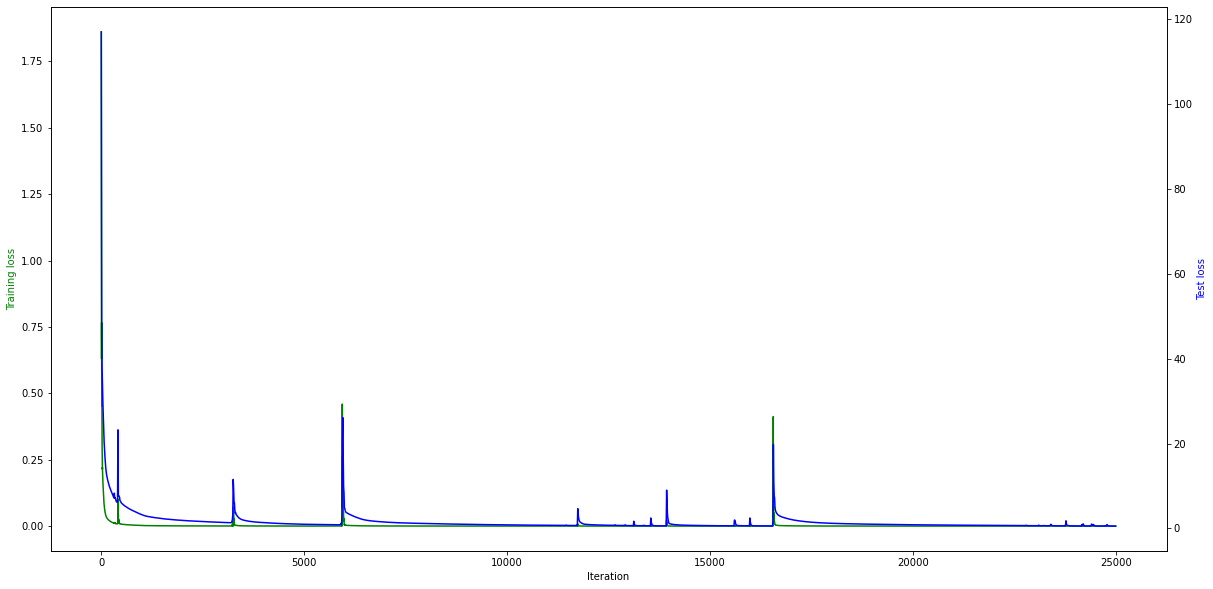

In [37]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(np.arange(len(list_training_loss)), list_training_loss, 'g-')
ax2.plot(np.arange(len(list_test_pred_error))*num_iter_test, list_test_pred_error, 'b-')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training loss', color='g')
ax2.set_ylabel('Test loss', color='b')

best_iter = (np.where(np.asarray(list_training_loss)==np.min(list_training_loss))[0][0]//num_iter_test)*num_iter_test
best_pred_error = list_test_pred_error[best_iter//num_iter_test]
print ('Best predictions at iter: %d (error: %f)' % (best_iter, best_pred_error))
RMSE = np.sqrt(np.square(best_pred_error)/np.sum(Otest))
print ('RMSE: %f' % RMSE)

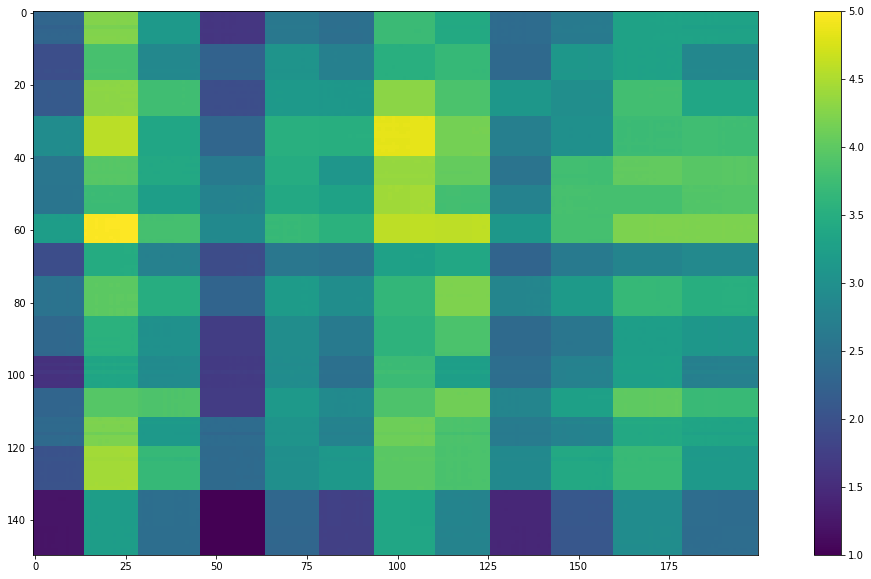

In [38]:
#best X generated
plt.figure(figsize=(20,10))
plt.imshow(list_X[best_iter//num_iter_test])
plt.colorbar()